In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/semeion-demo/semeion.data
/kaggle/input/musk-demo/musk.data


In [2]:
import cupy as cp
import numpy as np
from scipy.linalg import sqrtm, svd
from scipy.optimize import minimize
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import KFold
from sklearn.neighbors import KNeighborsClassifier
import matplotlib.pyplot as plt
import pandas as pd

In [3]:
# === Softmax ===
def softmax(W, X):
    logits = X @ W
    logits -= np.max(logits, axis=1, keepdims=True)
    exp_logits = np.exp(logits)
    probs = exp_logits / np.sum(exp_logits, axis=1, keepdims=True)
    return probs 

# === Matrix square root ===
def real_sqrtm(M):
    M_np = cp.asnumpy(M)
    return cp.asarray(sqrtm(M_np + 1e-6 * np.eye(M_np.shape[0])).real)

# === Scatter matrices ===
def compute_scatter_matrices(X, y):
    n_features = X.shape[1]
    classes = cp.unique(y)
    overall_mean = X.mean(axis=0)
    Sb = cp.zeros((n_features, n_features))
    Sw = cp.zeros((n_features, n_features))
    for c in classes:
        X_c = X[y == c]
        mean_c = X_c.mean(axis=0)
        n_c = X_c.shape[0]
        Sb += n_c * cp.outer(mean_c - overall_mean, mean_c - overall_mean)
        Sw += (X_c - mean_c).T @ (X_c - mean_c)
    return Sb, Sw  

In [4]:
# === S2FS ===
def S2FS(X, y, alpha, lambda_, max_iter=200, tol=1e-4, print_interval=30):
    X = cp.asarray(X)
    y = cp.asarray(y)
    n_samples, n_features = X.shape
    n_classes = len(cp.unique(y))
    Y = cp.eye(n_classes)[y]

    Sb, Sw = compute_scatter_matrices(X, y)
    Sb_sqrt = real_sqrtm(Sb)  
    inv_Sb_sqrt = cp.asarray(np.linalg.pinv(cp.asnumpy(Sb_sqrt))) 

    W = cp.random.randn(n_features, n_classes)
    M = cp.zeros_like(W)
    O = W.copy()
    Lambda1 = cp.zeros_like(W)
    Lambda2 = cp.zeros_like(W)

    mu = 1.0
    rho = 1.1

    for t in range(max_iter):
        # Update W via GPI
        A = inv_Sb_sqrt @ (cp.eye(n_features) + (alpha / mu) * Sw) @ inv_Sb_sqrt
        B = inv_Sb_sqrt @ (M + O - (Lambda1 + Lambda2) / mu)
        Q, _ = cp.linalg.qr(cp.random.randn(n_features, n_classes))
        for _ in range(10):
            A_np = cp.asnumpy(A)
            eigenvalues = np.linalg.eigvals(A_np)
            max_eig = np.max(np.abs(eigenvalues))
            tau = 1 / (2 * max_eig) if max_eig > 0 else 1.0
            T = 2 * (cp.eye(n_features) - tau * A) @ Q + B
            U, _, Vt = svd(cp.asnumpy(T), full_matrices=False)
            Q = cp.asarray(U @ Vt)
        W_new = Sb_sqrt @ Q  

        # M update
        threshold = cp.sqrt(2 * lambda_ / mu)
        M_temp = W_new - Lambda1 / mu
        row_norms = cp.linalg.norm(M_temp, axis=1)
        M_new = cp.where(row_norms[:, None] > threshold, M_temp, 0)

        # O update
        def loss_and_grad(O_vec):
            O_mat = O_vec.reshape(n_features, n_classes)
            probs = softmax(O_mat, cp.asnumpy(X))
            loss = -np.sum(cp.asnumpy(Y) * np.log(probs + 1e-12)) / n_samples
            loss += (mu / 2) * np.linalg.norm(O_mat - cp.asnumpy(W_new - Lambda2 / mu))**2
            grad = cp.asnumpy(X).T @ (probs - cp.asnumpy(Y)) / n_samples + mu * (O_mat - cp.asnumpy(W_new - Lambda2 / mu))
            return loss, grad.ravel()

        res = minimize(loss_and_grad, cp.asnumpy(O).ravel(), method='L-BFGS-B', jac=True)
        O_new = cp.asarray(res.x.reshape(n_features, n_classes))

        # Check convergence
        if cp.linalg.norm(W_new - M_new) < tol and cp.linalg.norm(W_new - O_new) < tol:
            print(f"Converged at iteration {t}")
            break

        # Update variables
        Lambda1 += mu * (W_new - M_new)
        Lambda2 += mu * (W_new - O_new)
        mu *= rho
        W, M, O = W_new, M_new, O_new

        # Print number of selected features
        if (t + 1) % print_interval == 0:
            feature_scores = cp.linalg.norm(W, axis=1)
            selected = feature_scores > cp.sqrt(2 * lambda_ / mu)
            n_selected_features = cp.sum(selected)
            print(f"Iteration {t + 1}: Number of selected features = {n_selected_features}")
            
    return cp.asnumpy(W), mu

In [34]:
# Load the dataset
df = pd.read_csv('/kaggle/input/musk-demo/musk.data', header=None)
print("Dataset loaded successfully")
print(f"Dataset shape: {df.shape}")
print("First few rows:\n", df.head())
print("Column count:", df.shape[1])

# Extract features and labels
X = df.iloc[:, 2:-1].values  
y_raw = df.iloc[:, -1].values  
print(f"Feature matrix shape: {X.shape}")
print(f"Label array shape: {y_raw.shape}")

# Randomly select 1000 rows
from sklearn.utils import resample
X_sampled, y_sampled = resample(X, y_raw, n_samples=1000, random_state=42)
print(f"Sampled feature matrix shape: {X_sampled.shape}")
print(f"Sampled label array shape: {y_sampled.shape}")

# Preprocessing
y = LabelEncoder().fit_transform(y_sampled)
X = StandardScaler().fit_transform(X_sampled)
print(f"Encoded labels shape: {y.shape}")
print(f"Scaled feature matrix shape: {X.shape}")

Dataset loaded successfully
Dataset shape: (6598, 169)
First few rows:
         0         1    2    3    4    5    6    7    8    9    ...  159  160  \
0  MUSK-211   211_1+1   46 -108  -60  -69 -117   49   38 -161  ... -308   52   
1  MUSK-211  211_1+10   41 -188 -145   22 -117   -6   57 -171  ...  -59   -2   
2  MUSK-211  211_1+11   46 -194 -145   28 -117   73   57 -168  ... -134 -154   
3  MUSK-211  211_1+12   41 -188 -145   22 -117   -7   57 -170  ...  -60   -4   
4  MUSK-211  211_1+13   41 -188 -145   22 -117   -7   57 -170  ...  -60   -4   

   161  162  163  164  165  166  167  168  
0   -7   39  126  156  -50 -112   96  1.0  
1   52  103  136  169  -61 -136   79  1.0  
2   57  143  142  165  -67 -145   39  1.0  
3   52  104  136  168  -60 -135   80  1.0  
4   52  104  137  168  -60 -135   80  1.0  

[5 rows x 169 columns]
Column count: 169
Feature matrix shape: (6598, 166)
Label array shape: (6598,)
Sampled feature matrix shape: (1000, 166)
Sampled label array shape: (1000,)
Enc

In [5]:
# Load the dataset
df = pd.read_csv('/kaggle/input/semeion-demo/semeion.data', header=None, sep='\s+')
print("Dataset loaded successfully")
print(f"Dataset shape: {df.shape}")
print("First few rows:\n", df.head())
print("Column count:", df.shape[1])

# Extract features and labels
X = df.iloc[:, :256].values  
y_one_hot = df.iloc[:, 256:].values 
y = np.argmax(y_one_hot, axis=1) 
print(f"Feature matrix shape: {X.shape}")
print(f"Label array shape: {y.shape}")

# Randomly select 1000 rows
from sklearn.utils import resample
X_sampled, y_sampled = resample(X, y, n_samples=1000, random_state=42)
print(f"Sampled feature matrix shape: {X_sampled.shape}")
print(f"Sampled label array shape: {y_sampled.shape}")

# Preprocess
from sklearn.preprocessing import LabelEncoder, StandardScaler
y = LabelEncoder().fit_transform(y_sampled)
X = StandardScaler().fit_transform(X_sampled)
print(f"Encoded labels shape: {y.shape}")
print(f"Scaled feature matrix shape: {X.shape}")

Dataset loaded successfully
Dataset shape: (1593, 266)
First few rows:
    0    1    2    3    4    5    6    7    8    9    ...  256  257  258  259  \
0  0.0  0.0  0.0  0.0  0.0  0.0  1.0  1.0  1.0  1.0  ...    1    0    0    0   
1  0.0  0.0  0.0  0.0  0.0  1.0  1.0  1.0  1.0  1.0  ...    1    0    0    0   
2  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  1.0  ...    1    0    0    0   
3  0.0  0.0  0.0  0.0  0.0  0.0  1.0  1.0  1.0  1.0  ...    1    0    0    0   
4  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  1.0  ...    1    0    0    0   

   260  261  262  263  264  265  
0    0    0    0    0    0    0  
1    0    0    0    0    0    0  
2    0    0    0    0    0    0  
3    0    0    0    0    0    0  
4    0    0    0    0    0    0  

[5 rows x 266 columns]
Column count: 266
Feature matrix shape: (1593, 256)
Label array shape: (1593,)
Sampled feature matrix shape: (1000, 256)
Sampled label array shape: (1000,)
Encoded labels shape: (1000,)
Scaled feature matrix shape: (100

In [6]:
# Hyperparameter lists 
alpha_list = [0.0001, 0.001] 
lambda_list = [0.0001, 0.001]  

# 5-fold cross-validation
kf = KFold(n_splits=3, shuffle=True, random_state=42)
best_acc = 0
best_params = None
best_W = None
best_mu = None
final_scores = None
sorted_indices = None

for alpha in alpha_list:
    for lambda_ in lambda_list:
        print(f"Training with α={alpha}, λ={lambda_}")
        accuracies = []
        for train_idx, val_idx in kf.split(X):
            X_train, X_val = X[train_idx], X[val_idx]
            y_train, y_val = y[train_idx], y[val_idx]
            W, mu_final = S2FS(X_train, y_train, alpha, lambda_, max_iter=150)
            feature_scores = np.linalg.norm(W, axis=1)
            selected = np.argsort(feature_scores)[::-1][:int(0.1 * X.shape[1])]
            clf = KNeighborsClassifier(n_neighbors=5)
            clf.fit(X_train[:, selected], y_train)
            acc = clf.score(X_val[:, selected], y_val)
            accuracies.append(acc)
        avg_acc = np.mean(accuracies)
        print(f"Average Validation Accuracy: {avg_acc:.4f}")
        if avg_acc > best_acc:
            best_acc = avg_acc
            best_params = (alpha, lambda_)
            best_W = W
            best_mu = mu_final
            final_scores = np.linalg.norm(best_W, axis=1)
            sorted_indices = np.argsort(final_scores)[::-1]

Training with α=0.0001, λ=0.0001
Iteration 30: Number of selected features = 0
Iteration 60: Number of selected features = 131
Iteration 90: Number of selected features = 52
Iteration 120: Number of selected features = 118
Iteration 150: Number of selected features = 180
Iteration 30: Number of selected features = 0
Iteration 60: Number of selected features = 160
Iteration 90: Number of selected features = 49
Iteration 120: Number of selected features = 122
Iteration 150: Number of selected features = 191
Iteration 30: Number of selected features = 0
Iteration 60: Number of selected features = 144
Iteration 90: Number of selected features = 52
Iteration 120: Number of selected features = 132
Iteration 150: Number of selected features = 191
Average Validation Accuracy: 0.6530
Training with α=0.0001, λ=0.001
Iteration 30: Number of selected features = 0
Iteration 60: Number of selected features = 0
Iteration 90: Number of selected features = 11
Iteration 120: Number of selected features 

In [7]:
# Final selected feature count
final_threshold = np.sqrt(2 * best_params[1] / best_mu)
selected_features = final_scores > final_threshold
n_selected = np.sum(selected_features)

print("\nBest Hyperparameters:")
print(f"Alpha = {best_params[0]}, Lambda = {best_params[1]}")
print(f"Best Average Validation Accuracy: {best_acc:.4f}")
print(f"Number of Selected Features (||w_i|| > √(2λ/μ)): {n_selected}")


Best Hyperparameters:
Alpha = 0.001, Lambda = 0.0001
Best Average Validation Accuracy: 0.6900
Number of Selected Features (||w_i|| > √(2λ/μ)): 196


Ratio: 0.02, Features: 5, Accuracy: 0.4490
Ratio: 0.04, Features: 10, Accuracy: 0.6310
Ratio: 0.06, Features: 15, Accuracy: 0.7270
Ratio: 0.08, Features: 20, Accuracy: 0.7540
Ratio: 0.10, Features: 25, Accuracy: 0.8070
Ratio: 0.12, Features: 30, Accuracy: 0.8280
Ratio: 0.14, Features: 35, Accuracy: 0.8250
Ratio: 0.16, Features: 40, Accuracy: 0.8370
Ratio: 0.18, Features: 46, Accuracy: 0.8650
Ratio: 0.20, Features: 51, Accuracy: 0.8670


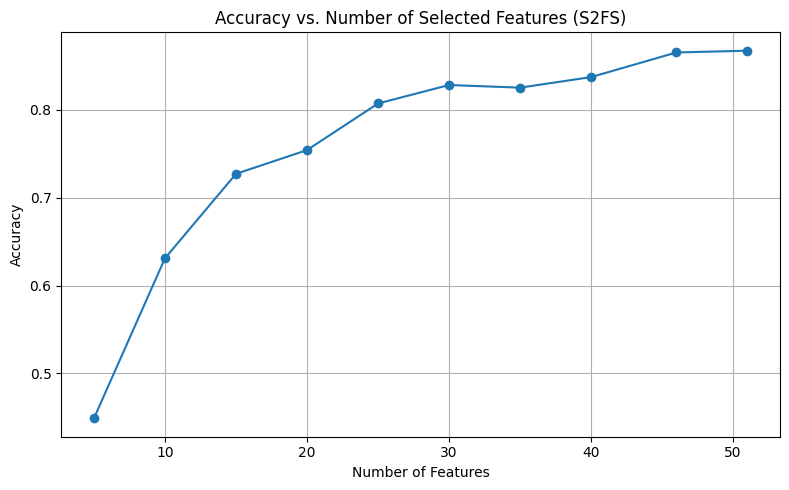

In [9]:
# Accuracy vs. Feature Ratio Plot
ratios = np.linspace(0.02, 0.2, 10)
accuracies = []
feature_counts = []

for r in ratios:
    k = max(1, int(r * X.shape[1]))
    selected = sorted_indices[:k]
    clf = KNeighborsClassifier(n_neighbors=5)
    clf.fit(X[:, selected], y)  
    acc = clf.score(X[:, selected], y) 
    accuracies.append(acc)
    feature_counts.append(k)
    print(f"Ratio: {r:.2f}, Features: {k}, Accuracy: {acc:.4f}")

plt.figure(figsize=(8, 5))
plt.plot(feature_counts, accuracies, marker='o')
plt.title("Accuracy vs. Number of Selected Features (S2FS)")
plt.xlabel("Number of Features")
plt.ylabel("Accuracy")
# plt.ylim(0.8, 0.98)  
plt.grid(True)
plt.tight_layout()
plt.show()


Testing lambda = 0.0001
Iteration 30: Number of selected features = 0
Iteration 60: Number of selected features = 130
Iteration 90: Number of selected features = 50
Iteration 120: Number of selected features = 109
Iteration 150: Number of selected features = 174
Fold 1 accuracy: 0.6647
Iteration 30: Number of selected features = 0
Iteration 60: Number of selected features = 157
Iteration 90: Number of selected features = 51
Iteration 120: Number of selected features = 122
Iteration 150: Number of selected features = 185
Fold 2 accuracy: 0.6757
Iteration 30: Number of selected features = 0
Iteration 60: Number of selected features = 143
Iteration 90: Number of selected features = 56
Iteration 120: Number of selected features = 139
Iteration 150: Number of selected features = 195
Fold 3 accuracy: 0.6997
Average Validation Accuracy (alpha=0, lambda=0.0001): 0.6800

Testing lambda = 0.001
Iteration 30: Number of selected features = 0
Iteration 60: Number of selected features = 0
Iteration

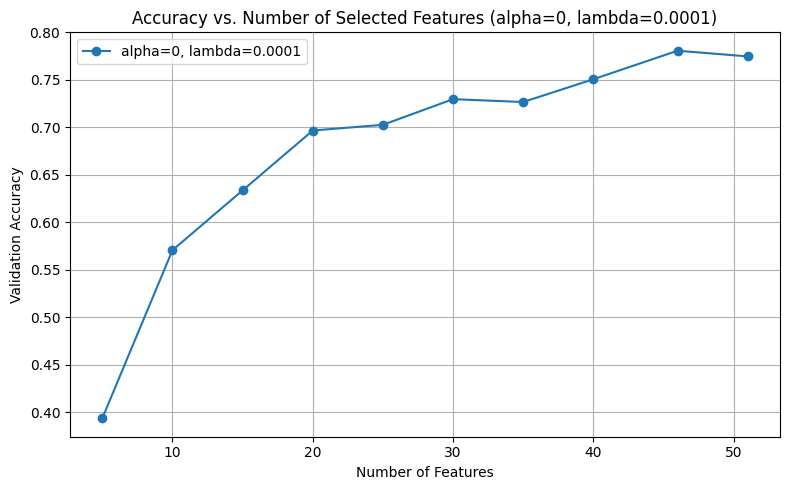

In [11]:
# Ablation Study: 5-fold cross-validation with alpha = 0 to find best lambda
alpha_ablation = 0
best_lambda = None
best_acc = 0

for lambda_ablation in lambda_list:
    print(f"\nTesting lambda = {lambda_ablation}")
    accuracies = []
    for fold, (train_idx, val_idx) in enumerate(kf.split(X), 1):
        X_train, X_val = X[train_idx], X[val_idx]
        y_train, y_val = y[train_idx], y[val_idx]
        W_ablation, mu_ablation = S2FS(X_train, y_train, alpha_ablation, lambda_ablation, max_iter=150)
        feature_scores_ablation = np.linalg.norm(W_ablation, axis=1)
        selected_ablation = np.argsort(feature_scores_ablation)[::-1][:int(0.1 * X.shape[1])]
        clf_ablation = KNeighborsClassifier(n_neighbors=5)
        clf_ablation.fit(X_train[:, selected_ablation], y_train)
        acc_ablation = clf_ablation.score(X_val[:, selected_ablation], y_val)
        accuracies.append(acc_ablation)
        print(f"Fold {fold} accuracy: {acc_ablation:.4f}")
    avg_acc_ablation = np.mean(accuracies)
    print(f"Average Validation Accuracy (alpha=0, lambda={lambda_ablation}): {avg_acc_ablation:.4f}")
    if avg_acc_ablation > best_acc:
        best_acc = avg_acc_ablation
        best_lambda = lambda_ablation

print(f"\nBest lambda with alpha=0: {best_lambda}, Best Average Accuracy: {best_acc:.4f}")

# Ablation Study with best lambda (alpha=0)
print("\nAblation Study: Running with best lambda and alpha=0")
accuracies_best = []
for train_idx, val_idx in kf.split(X):
    X_train, X_val = X[train_idx], X[val_idx]
    y_train, y_val = y[train_idx], y[val_idx]
    W_best, mu_best = S2FS(X_train, y_train, alpha_ablation, best_lambda, max_iter=150)
    feature_scores_best = np.linalg.norm(W_best, axis=1)
    selected_best = np.argsort(feature_scores_best)[::-1][:int(0.1 * X.shape[1])]
    clf_best = KNeighborsClassifier(n_neighbors=5)
    clf_best.fit(X_train[:, selected_best], y_train)
    acc_best = clf_best.score(X_val[:, selected_best], y_val)
    accuracies_best.append(acc_best)
avg_acc_best = np.mean(accuracies_best)
print(f"Validation Accuracy with alpha=0, lambda={best_lambda}: {avg_acc_best:.4f}")

# Final selected features using threshold
final_threshold_best = np.sqrt(2 * best_lambda / mu_best)
selected_features_best = feature_scores_best > final_threshold_best
n_selected_best = np.sum(selected_features_best)
print(f"Number of Selected Features (||w_i|| > √(2λ/μ)): {n_selected_best}")

# Accuracy vs. Feature Ratio for best lambda
ratios = np.linspace(0.02, 0.2, 10)
accuracies_ratio = []
feature_counts_best = []
sorted_indices_best = np.argsort(feature_scores_best)[::-1]

for r in ratios:
    k = max(1, int(r * X.shape[1]))
    selected = sorted_indices_best[:k]
    clf = KNeighborsClassifier(n_neighbors=5)
    clf.fit(X_train[:, selected], y_train)
    acc = clf.score(X_val[:, selected], y_val)
    accuracies_ratio.append(acc)
    feature_counts_best.append(k)
    print(f"Ratio: {r:.2f}, Features: {k}, Accuracy: {acc:.4f}")

# Plot for best lambda with alpha=0
plt.figure(figsize=(8, 5))
plt.plot(feature_counts_best, accuracies_ratio, marker='o', label=f'alpha=0, lambda={best_lambda}')
plt.title(f"Accuracy vs. Number of Selected Features (alpha=0, lambda={best_lambda})")
plt.xlabel("Number of Features")
plt.ylabel("Validation Accuracy")
# plt.ylim(0.8, 0.98)
plt.grid(True)
plt.legend()
plt.tight_layout()